# Bayesian Inference in the Poisson HMM

In this notebook we will fit a Hidden Markov Model. This content is based on Professor Scott Linderman's slides for the (Spring 2021) Stanford course STATS 271 ([Part 1](https://github.com/slinderman/stats271sp2021/blob/main/slides/lap7_hmms.pdf), [Part 2](https://github.com/slinderman/stats271sp2021/blob/main/slides/lap7_hmms_b.pdf)) and Chapter 23 from "Bayesian Reasoning and Machine Learning" (Barber, 2012).

Mathematically, let $\mathbf{x}_t^{(v)} \in \mathbb{R}^{p}$ and $y_t^{(v)}$ denote the combined features and case counts, respectively, at time step $t$ of the $v$-th event, and let $\mathbf{x}_{1:T_i}^{(v)} = (\mathbf{x}_1^{(v)}, \ldots, \mathbf{x}_{T_v}^{(v)})$ and $y_{1:T_i}^{(v)} = (y_1^{(v)}, \ldots, y_{T_v}^{(v)})$ denote the full sequence of features and case counts, respectively, for the $v$-th event, where $T_v$ is the number of time steps. Likewise, let $z_{1:T_v}^{(v)} = (z_1^{(v)}, \ldots, z_{T_v}^{(v)})$ denote the sequence of discrete states for the $i$-th event.

The joint distribution of the complete dataset is,

\begin{align}
p(\{(z_{1:T_v}^{(v)}, y_{1:T_v}^{(v)}\}_{v=1}^V \mid \{\mathbf{x}_{1:T_v}^{(v)}\}_{v=1}^V, \Theta) 
&= \prod_{v=1}^V p(z_{1:T_v}^{(v)}, y_{1:T_v}^{(v)} \mid \mathbf{x}_{1:T_v}^{(v)}, \Theta) \\
&= \prod_{v=1}^V \left[p(z_1^{(v)} \mid \Theta) \prod_{t=2}^{T_v} p(z_{t}^{(v)} \mid z_{t-1}^{(v)} , \Theta)  \prod_{t=1}^{T_v} p(y_{t}^{(v)} \mid z_{t}^{(v)}, \mathbf{x}_{t}^{(v)}, \Theta) \right]
\end{align}

The goal is to find the parameters $\Theta$ that maximize the marginal likelihood of the data by using EM. Then we'll use cross validation, holding out a random subset of events, to determine the number of discrete states. Finally, we'll visualize the inferred states in terms of the distribution over features.

# Model

<img src="../hmm.png" width="400">

\begin{align}
\theta_k \sim Dirichlet_k(\alpha)\\
z_t\sim Discrete(\theta_{z_{t-1}})\\
\mu_k\sim Normal(0, \sigma)\\
y_t \sim Poisson(\mu_{z_t}^T\mathbf{x}_t)
\end{align}



# EM for Poissson GLM

The Expectation-Maximization (EM) algorithm performs coordinate ascent on parameters and latent variable posteriors. The **E-step** computes an update of the posteror over latent variables: 

$$q\leftarrow p(z\mid x, y, \Theta)$$

Then, the **M-step**, maximizes the expected log probability

\begin{align}
    \Theta\leftarrow\arg \max_\Theta \;\mathbb{E}_{q(z)}[\log p(x,z,,y,\Theta)]
\end{align}

## E-step: Running the forward-backward algorithm

Consider the marginal probability of state $k$ at time $t$

\begin{align}
    q(z_t=k) & = \sum_{z_1=1}^K\dots\sum_{z_{t-1}=1}^K\sum_{z_{t+1}=1}^K\dots\sum_{z_T=1}^Kq(z_1,\dots,z_{t-1},z_t=k,z_{t+1},\dots,z_T)\\
    & \propto \left[\sum_{z_1=1}^K\dots\sum_{z_{t-1}=1}^Kp(z_1)\prod_{s=1}^{t-1}p(y_s\mid \mu_{z_s}^T\mathbf{x}_s)p(z_{s+1}\mid z_s)\right]\times \left[p(y_t\mid\mu_k^T\mathbf{x}_t)\right]\\
    & \times \left[\sum_{z_{t+1}=1}^K\dots\sum_{z_{T}=1}^K\prod_{u=t+1}^{T}p(z_{u}\mid z_{u-1})p(y_u\mid \mu_{z_u}^T\mathbf{x}_u)\right]\\
    & \triangleq \alpha_t(z_t=k)\times p(y_t\mid\mu_k^T\mathbf{x}_t) \times \beta_t(z_t=k)
\end{align}

Where $\alpha_t(z_t)$ and $\beta_t(z_t)$ are generally known as the forward and backward messages, respectively. These messages can be computed efficiently by recursion:

\begin{align}
    \alpha(z_t=k)=\sum_{z_{t-1}=1}^K\alpha_{t-1}(z_{t-1})p(y_{t-1}\mid\mu_{z_{t-1}}^T\mathbf{x}_{t-1})p(z_t=k\mid z_{t-1})\\
    \beta(z_t=k)=\sum_{z_{t+1}=1}^Kp(z_{t+1}\mid z_{t}=k)p(y_{t+1}\mid\mu_{z_{t+1}}^T\mathbf{x}_{t+1})\beta_{t-1}(z_{t+1})
\end{align}

Finally, the probabilities need to sum to one. Normalizing yields,

\begin{align}
q(z_t=k)=\frac{\alpha_t(z_t=k) p(y_t\mid\mu_k^T\mathbf{x}_t)  \beta_t(z_t=k)}{\sum_{k=1}^K\alpha_t(z_t=k) p(y_t\mid\mu_k^T\mathbf{x}_t)  \beta_t(z_t=k)}
\end{align}

We can also use this forward-backward algorithm to compute the transition marginals $q(z_t=i, z_{t+1}=j)$

\begin{align}
q(z_t=i, z_{t+1}=j)=\frac{\alpha_t(z_t=i) p(y_t\mid\mu_i^T\mathbf{x}_t)p(z_{t+1}=j \mid z_{t}=i)p(y_{t+1}\mid\mu_j^T\mathbf{x}_{t+1}) \beta_{t+1}(z_{t+1}=j)}{\sum_{i=1}^K\sum_{j=1}^K\alpha_t(z_t=i) p(y_t\mid\mu_i^T\mathbf{x}_t)p(z_{t+1}=j \mid z_{t}=i)p(y_{t+1}\mid\mu_j^T\mathbf{x}_{t+1}) \beta_{t+1}(z_{t+1}=j)}
\end{align}

which will be necessary to update the transition matrix.

## M-step: Updating the parameters

For this model, we have to estimate the parameters $\Theta=(\{\theta_k\}^K, \{\mu_k\}^K)$. First, let us rewrite the joint distribution of the complete dataset by replacing

\begin{align}
p(z_{t}^{(v)} \mid z_{t-1}^{(v)} , \Theta) & = \prod_{i=1}^K\prod_{j=1}^K\theta_{ij}^{\mathbb{I}(z_{t-1}=i)\mathbb{I}(z_{t}=j)}\\
p(y_{t}^{(v)} \mid z_{t}^{(v)}, \mathbf{x}_{t}^{(v)}, \Theta) & = \prod_{k=1}^Kp(y_{t}^{(v)} \mid \mu_k^T\mathbf{x}_{t}^{(v)})^{\mathbb{I}(z_{t}=k)}
\end{align}

\begin{align}
p(\{(z_{1:T_v}^{(v)}, y_{1:T_v}^{(v)}\}_{v=1}^V \mid \{\mathbf{x}_{1:T_v}^{(v)}\}_{v=1}^V, \Theta) 
&= \prod_{v=1}^V \left[p(z_1^{(v)} \mid \Theta) \prod_{t=2}^{T_v} p(z_{t}^{(v)} \mid z_{t-1}^{(v)} , \Theta)  \prod_{t=1}^{T_v} p(y_{t}^{(v)} \mid z_{t}^{(v)}, \mathbf{x}_{t}^{(v)}, \Theta) \right]\\
&= \prod_{v=1}^V \left[p(z_1^{(v)} \mid \Theta) \prod_{t=2}^{T_v} p(z_{t}^{(v)} \mid z_{t-1}^{(v)} , \Theta)  \prod_{t=1}^{T_v} p(y_{t}^{(v)} \mid z_{t}^{(v)}, \mathbf{x}_{t}^{(v)}, \Theta) \right]\\
\end{align}


## Most likely joint state: Viterbi algorithm




## Initialization

## Prediction

\begin{align}
p(y_{t+1}\mid y_{1:t},x_{1:t})= \sum_{z_t}\sum_{z_{t+1}}p(y_{t+1}\mid\mu_{z_{t+1}}^Tx_{t+1})p(z_{t+1}\mid z_t)p(z_t\mid y_{1:t},x_{1:t})
\end{align}

With

\begin{align}
p(z_t\mid y_{1:t},x_{1:t}) \propto \alpha_t(z_t)
\end{align}

Since $y_{1:t}$, then $\beta_t{z_t}=1$.

# In sample results

In [1]:
import sys
sys.path.append('../')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from src.d01_data.dengue_data_api import DengueDataApi
from src.d04_modeling.poisson_hmm import PoissonHMM

In [2]:
# plt.rcParams['font.size'] = '22'
# plt.rcParams['xtick.labelsize'] = '22'
# plt.rcParams['ytick.labelsize'] = '22'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'TeX Gyre Heros'

In [3]:
dda = DengueDataApi()
x_train, x_validate, y_train, y_validate = dda.split_data(random=False)
cities = y_train.index.get_level_values('city').unique()
run_static = True
city_dummy = False
no_glm = False
num_components = 4 if run_static else 3
num_states = 3
run_static = True if no_glm else run_static

In [4]:
from src.d04_modeling.dynamic_factor_model import DynamicFactorModel
if not run_static:
    dfm_model = DynamicFactorModel(x_train.copy(), y_train.copy(), factors=num_components, factor_orders=1, idiosyncratic_ar1=True)
    dfm_model.fit()

    z_train, y_train = dfm_model.get_filtered_factors(x_train.copy(), y_train.copy())
    z_validate, y_validate = dfm_model.get_filtered_factors(x_validate.copy(), y_validate.copy())

In [5]:
(y_validate - y_validate.groupby('city').mean()).abs().groupby('city').mean()

city
iq     7.711508
sj    17.108551
Name: total_cases, dtype: float64

In [6]:
(y_train - y_train.groupby('city').mean()).abs().groupby('city').mean()

city
iq     6.012955
sj    32.108828
Name: total_cases, dtype: float64

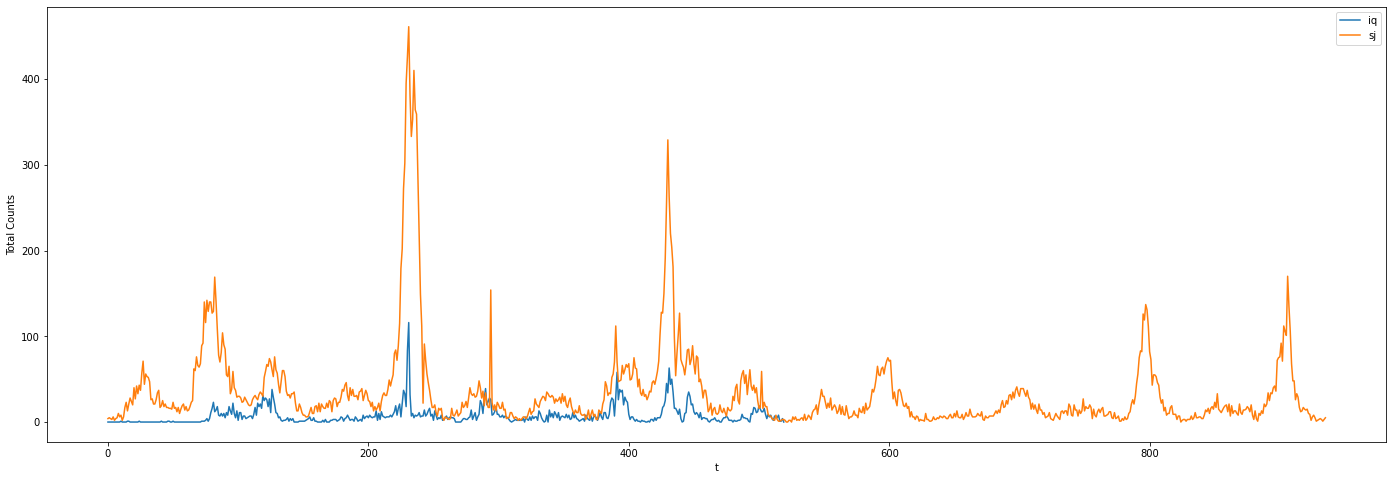

In [7]:
y_data = y_train.append(y_validate).sort_index()

fig, ax = plt.subplots(figsize=(24, 8))
ax.plot(y_data.loc['iq'].values, label='iq')
ax.plot(y_data.loc['sj'].values, label='sj')
ax.set_ylabel('Total Counts')
ax.set_xlabel('t')
ax.legend()
plt.show()

In [8]:
from src.d04_modeling.arx import ARX
if not run_static:
    arx_model = ARX(x_train=z_train.copy(), y_train=y_train.copy(), p={'iq': 2, 'sj': 3}, d=1)
    arx_model.fit()
    y_train_hat = []
    y_validate_hat = []
    for city in arx_model.get_cities():
        # print(city)
        y_train_hat += [arx_model.predict(city, z_train.copy())]
        y_validate_hat += [arx_model.predict(city, z_validate.copy())]
    y_train_hat = pd.concat(y_train_hat, axis=0, ignore_index=True)
    y_validate_hat = pd.concat(y_validate_hat, axis=0, ignore_index=True)
    mask = np.isnan(y_train).values
    y_train.loc[mask] = y_train_hat.loc[mask].round().values
    mask = np.isnan(y_validate).values
    y_validate.loc[mask] = y_validate_hat.loc[mask].round().values

    z_train['bias'] = 1.
    z_validate['bias'] = 1.

In [9]:
if run_static:
    num_components = 4
    z_train, z_validate, pct_var, _ = dda.get_pca(x_train.copy(), x_validate.copy(), num_components=num_components)
    z_train['bias'] = 1.
    z_validate['bias'] = 1.

In [10]:
if city_dummy:
    z_validate['sj'] = 0.
    z_validate.at[('sj', slice(None), slice(None)), 'sj'] = 1.
    z_train['sj'] = 0.
    z_train.at[('sj', slice(None), slice(None)), 'sj'] = 1.
if no_glm:
    columns2drop = z_train.columns[:num_components]
    z_train.drop(columns=columns2drop, inplace=True)
    z_validate.drop(columns=columns2drop, inplace=True)
print(z_train.head())
print(z_train.tail())

                                pc0       pc1       pc2       pc3  bias
city year week_start_date                                              
iq   2000 2000-07-01       2.732341  0.611302 -0.901929 -0.265362   1.0
          2000-07-08       3.480752  0.540752 -1.431484  0.270606   1.0
          2000-07-15       1.566949  0.338550 -2.809499  0.792046   1.0
          2000-07-22       2.220927  4.012572 -2.110429  0.498261   1.0
          2000-07-29       3.877287  1.994249 -1.082553 -0.424317   1.0
                                pc0       pc1       pc2       pc3  bias
city year week_start_date                                              
sj   2002 2002-11-26      -1.155444 -1.029509  1.330123 -1.257517   1.0
          2002-12-03      -2.536104 -0.038720  2.234666 -0.525085   1.0
          2002-12-10      -3.047320  0.146650  1.505943  0.063243   1.0
          2002-12-17      -2.610423  0.715169  1.230929 -0.049095   1.0
          2002-12-24      -2.299045  0.620086  0.015164  0.06908

In [11]:
print("np.isnan(z): ", np.isnan(z_train).any().any())
print("np.isnan(y): ", np.isnan(y_train).any().any())

np.isnan(z):  False
np.isnan(y):  False


In [12]:
model = PoissonHMM(num_states=num_states, seed=1992)
event_data = dict()
event_data['x'] = model.format_event_data(z_train.droplevel('year'))
event_data['y'] = model.format_event_data(y_train.droplevel('year'))

lls_k, parameters_k = model.fit(event_data=event_data)

Solving...............Done


In [13]:
from src.d04_modeling.poisson_glm import PoissonGLM

mu = parameters_k['mu']
expectations, marginal_ll, _ = model.e_step(event_data, parameters_k)
most_likely_states = model.viterbi(event_data=event_data, parameters=parameters_k)
expectations, x_data, y_data = model.glm_inputs_setup(event_data, expectations)
y_hat = np.zeros((y_data.shape[0], model.num_states))
for k in range(model.num_states):
    poisson_glm = PoissonGLM(x_train=x_data, y_train=y_data, weights=expectations[:, k].reshape((-1, 1)),
                             sigma2=model.sigma2, bias=False)

    y_hat[:, k] = poisson_glm.obs_map(mu[k], x_data).reshape(-1,)

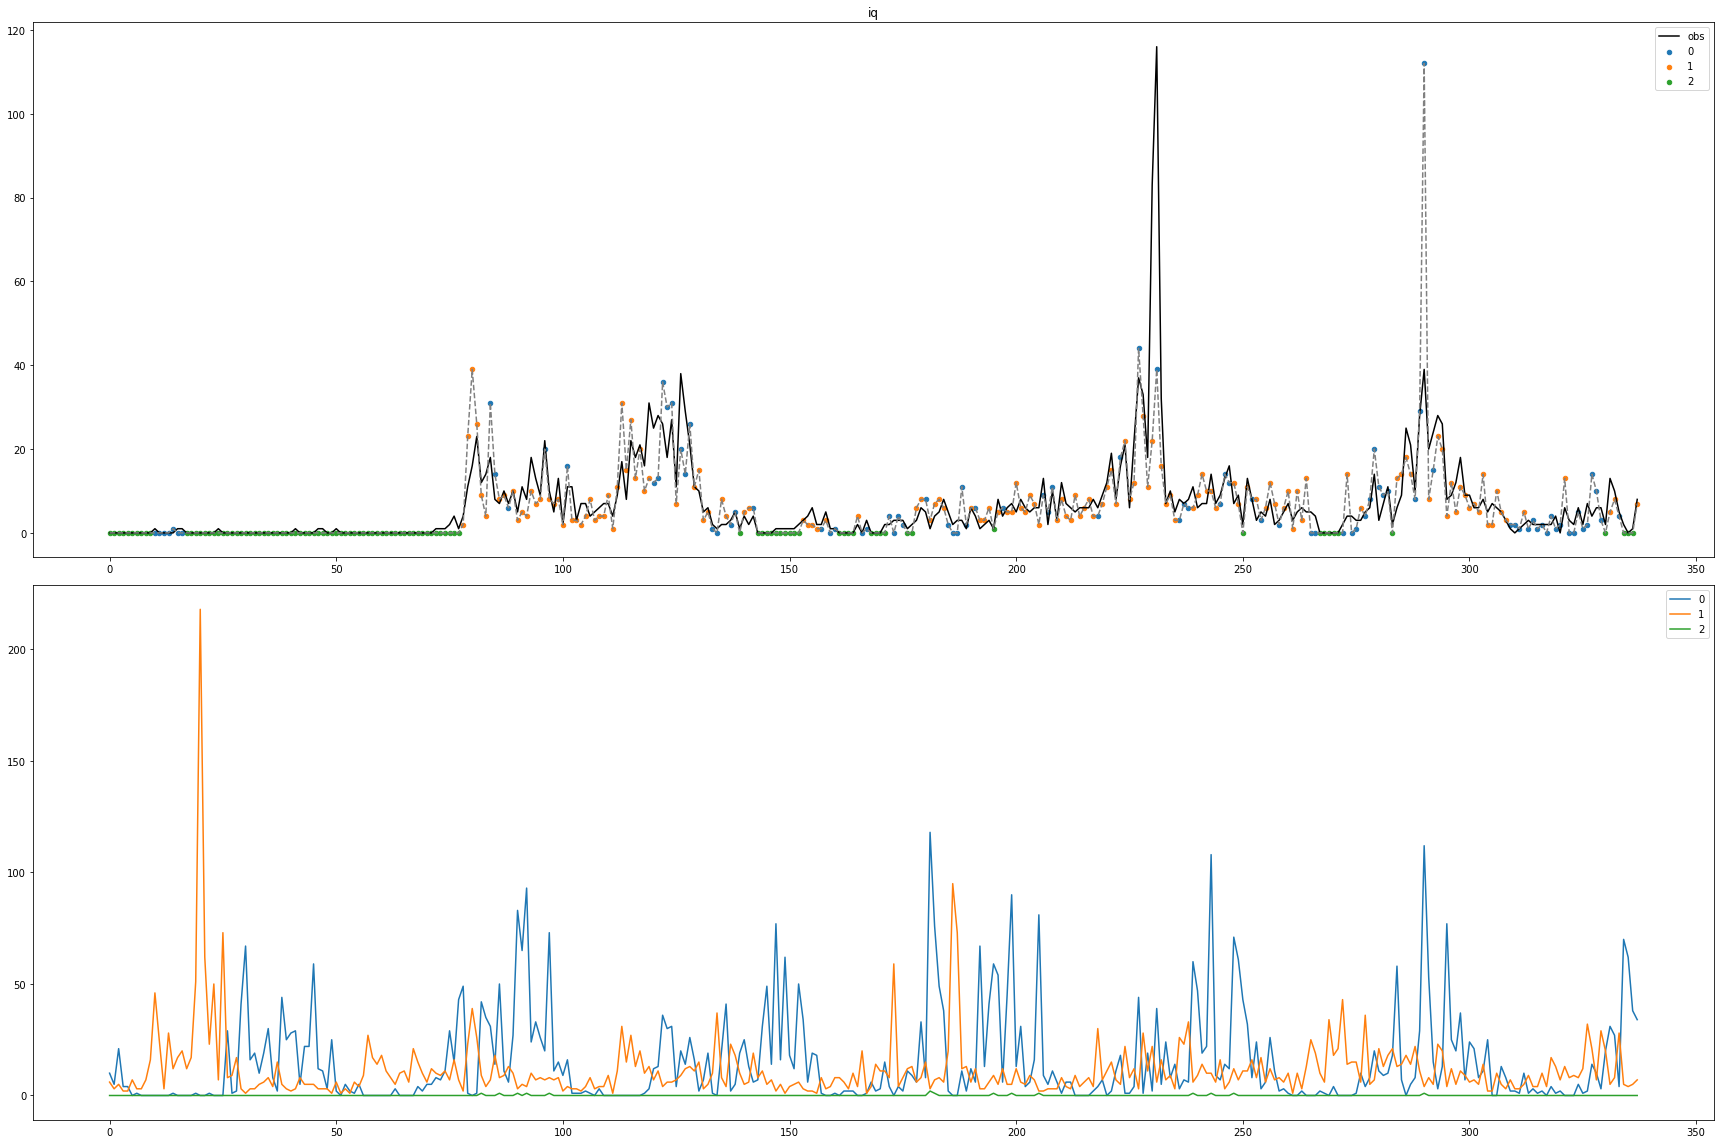

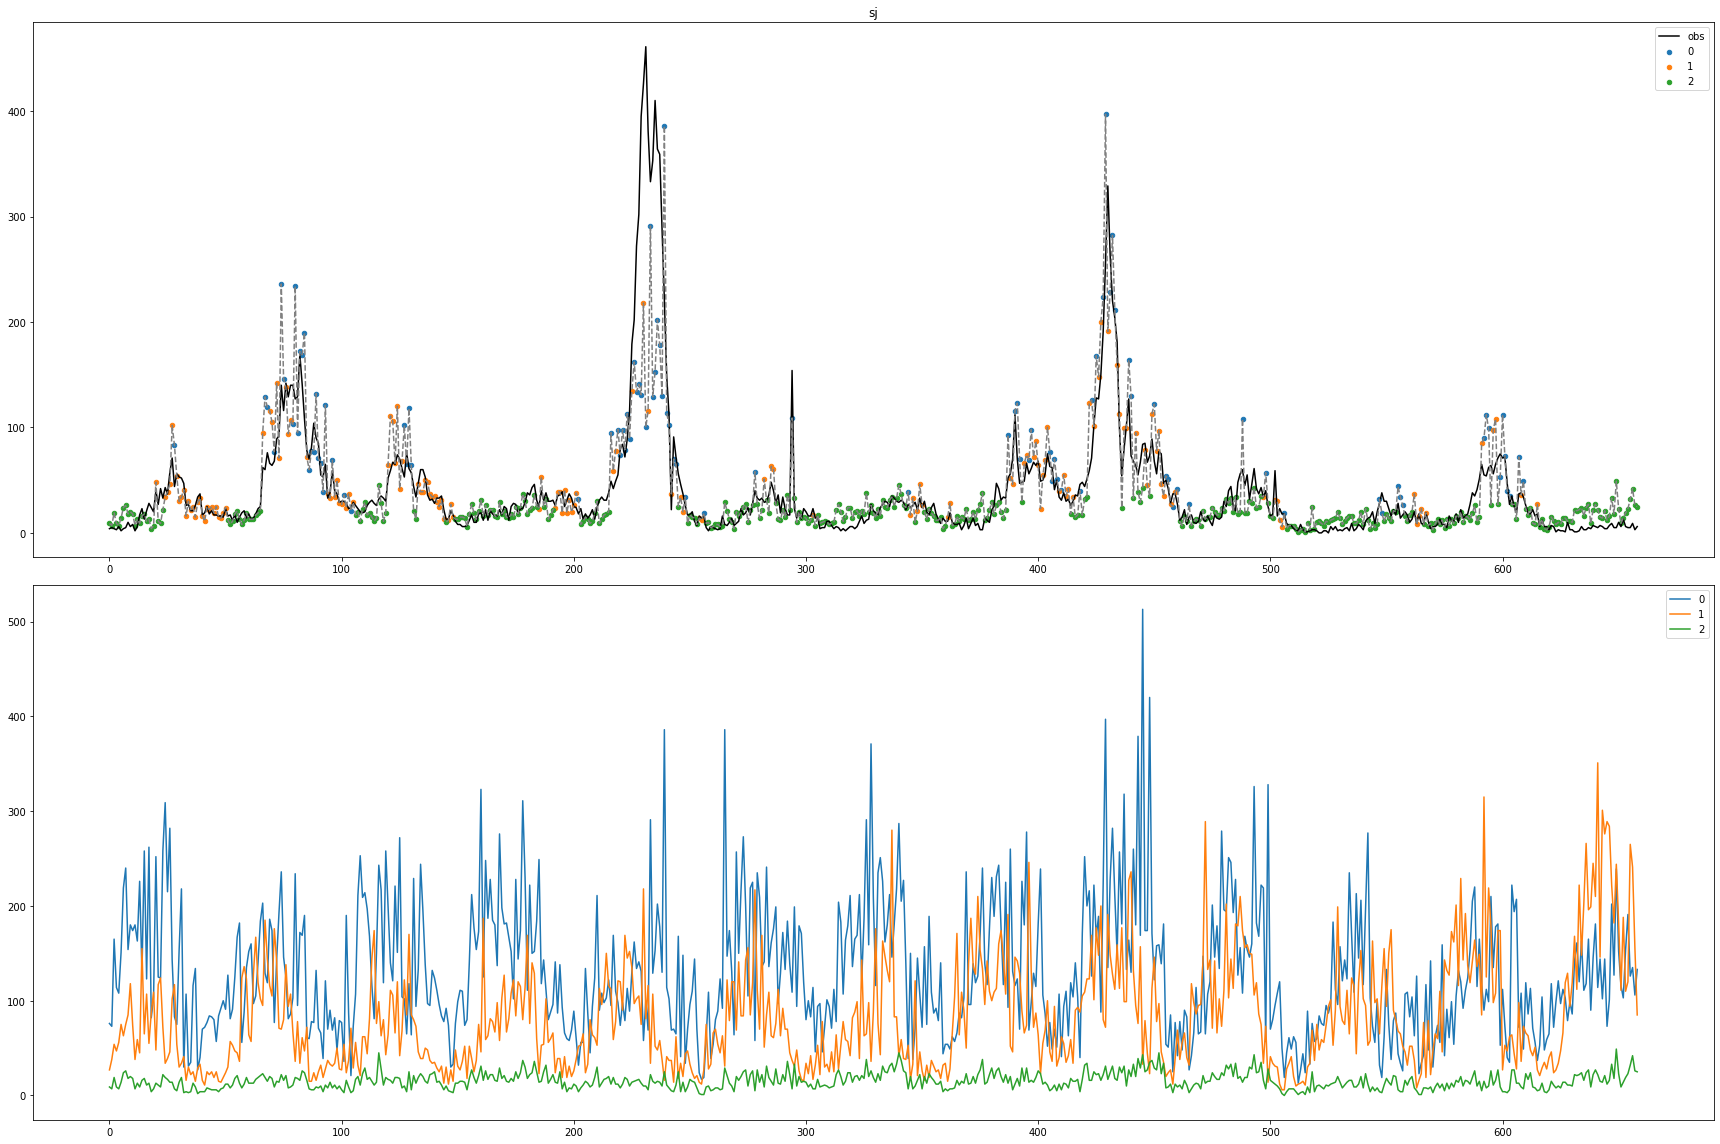

In [14]:
t0 = 0
l=250
for i in range(2):
    t1 = len(event_data['y'][i])+t0
    l = t1-t0
    # fig, ax2 = plt.subplots(figsize=(18, 2))
    # ax2.imshow(np.array(most_likely_states[i][-l:]).reshape((1,-1)))
    
    fig, ax = plt.subplots(nrows=2, figsize=(24, 16))
    t_range = np.arange(t1-t0)
    y_viterbi = np.zeros((t1-t0, model.num_states)) + np.nan
    for k in range(model.num_states):
        mask = np.array(most_likely_states[i]) == k
        ax[1].plot(y_hat[t0:t0+t1, k][-l:], label=k)
        ax[1].legend()
        # ax[2].plot(expectations[t0:t0+t1, k][-l:], label=k)
        # ax[2].legend()
        y_viterbi[mask, k] = 1.
        ax[0].scatter(t_range[mask][-l:], y_hat[t0:t0+t1, k][mask][-l:], label=k, s=20)
        
    
    y = event_data['y'][i][-l:]
    ax[0].plot(y, color='black', label='obs')
    ax[0].plot(np.nansum(y_hat[t0:t0+t1, :] * y_viterbi, axis=1)[-l:], color='gray', linestyle='dashed')
    # ax[0].plot(np.sum(y_hat[t0:t0+t1, :] * expectations[t0:t0+t1, :], axis=1)[-l:], label='average')
    ax[0].legend()
    ax[0].set_title(cities[i])
    # for x_, y_ in zip(np.arange(len(y)), y):
    #     ax[0].text(x_, y_+1, "%i" % most_likely_states[i][-l+int(x_)], color="black", fontsize=12)
    t0 += t1
    plt.tight_layout()
    # plt.show()
    plt.savefig('insample_%s.png' % cities[i])


[]

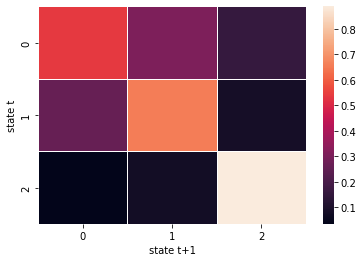

In [15]:
import seaborn as sns
ax = sns.heatmap(parameters_k['transition_matrix'], linewidth=0.5)
ax.set_ylabel('state t')
ax.set_xlabel('state t+1')
plt.plot()

[]

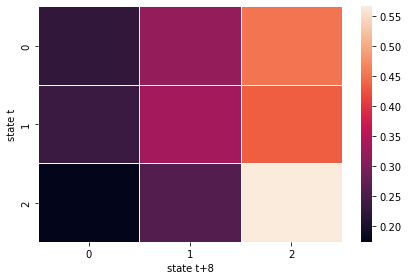

In [16]:
m=8
ax = sns.heatmap(np.linalg.matrix_power(parameters_k['transition_matrix'].T, m).T, linewidth=0.5)
ax.set_ylabel('state t')
ax.set_xlabel('state t+%i' % m)
plt.tight_layout()
plt.plot()

# Out of sample results

In [17]:
event_data_validate = dict()
event_data_validate['x'] = model.format_event_data(z_validate.droplevel('year'))
event_data_validate['y'] = model.format_event_data(y_validate.droplevel('year').interpolate())

forecasts, states_prob = model.forecast(event_data, event_data_validate, parameters_k, alpha=0.5, num_samples=500)

Sampling..................Done
Sampling...........................Done


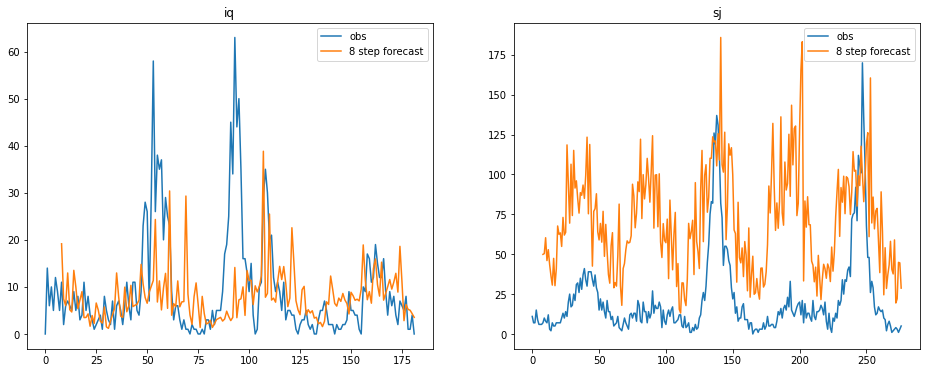

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
for i in range(2):
    t1 = len(event_data_validate['y'][i])+t0
    t = np.arange(t1-t0)
    y = event_data_validate['y'][i]
    ax[i].plot(t, y, label='obs')
    ax[i].plot(t, forecasts[i]['map'], label='8 step forecast')
    ax[i].legend()
    ax[i].set_title(cities[i])

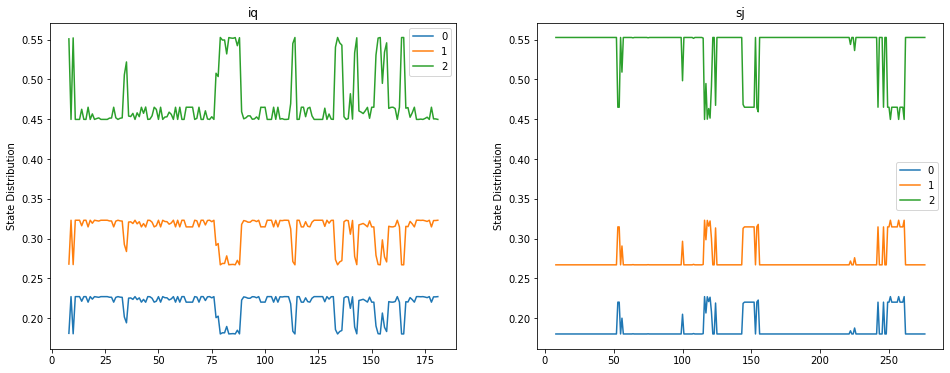

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))
for i in range(2):
    t1 = len(event_data_validate['y'][i])+t0
    t = np.arange(t1-t0)
    y = event_data_validate['y'][i]
    for k in range(model.num_states):
        ax[i].plot(t, states_prob[i][k], label=k)
    ax[i].legend()
    ax[i].set_ylabel('State Distribution')
    ax[i].set_title(cities[i])

[iq] Forecast MAE: 7.2219
[sj] Forecast MAE: 50.5807


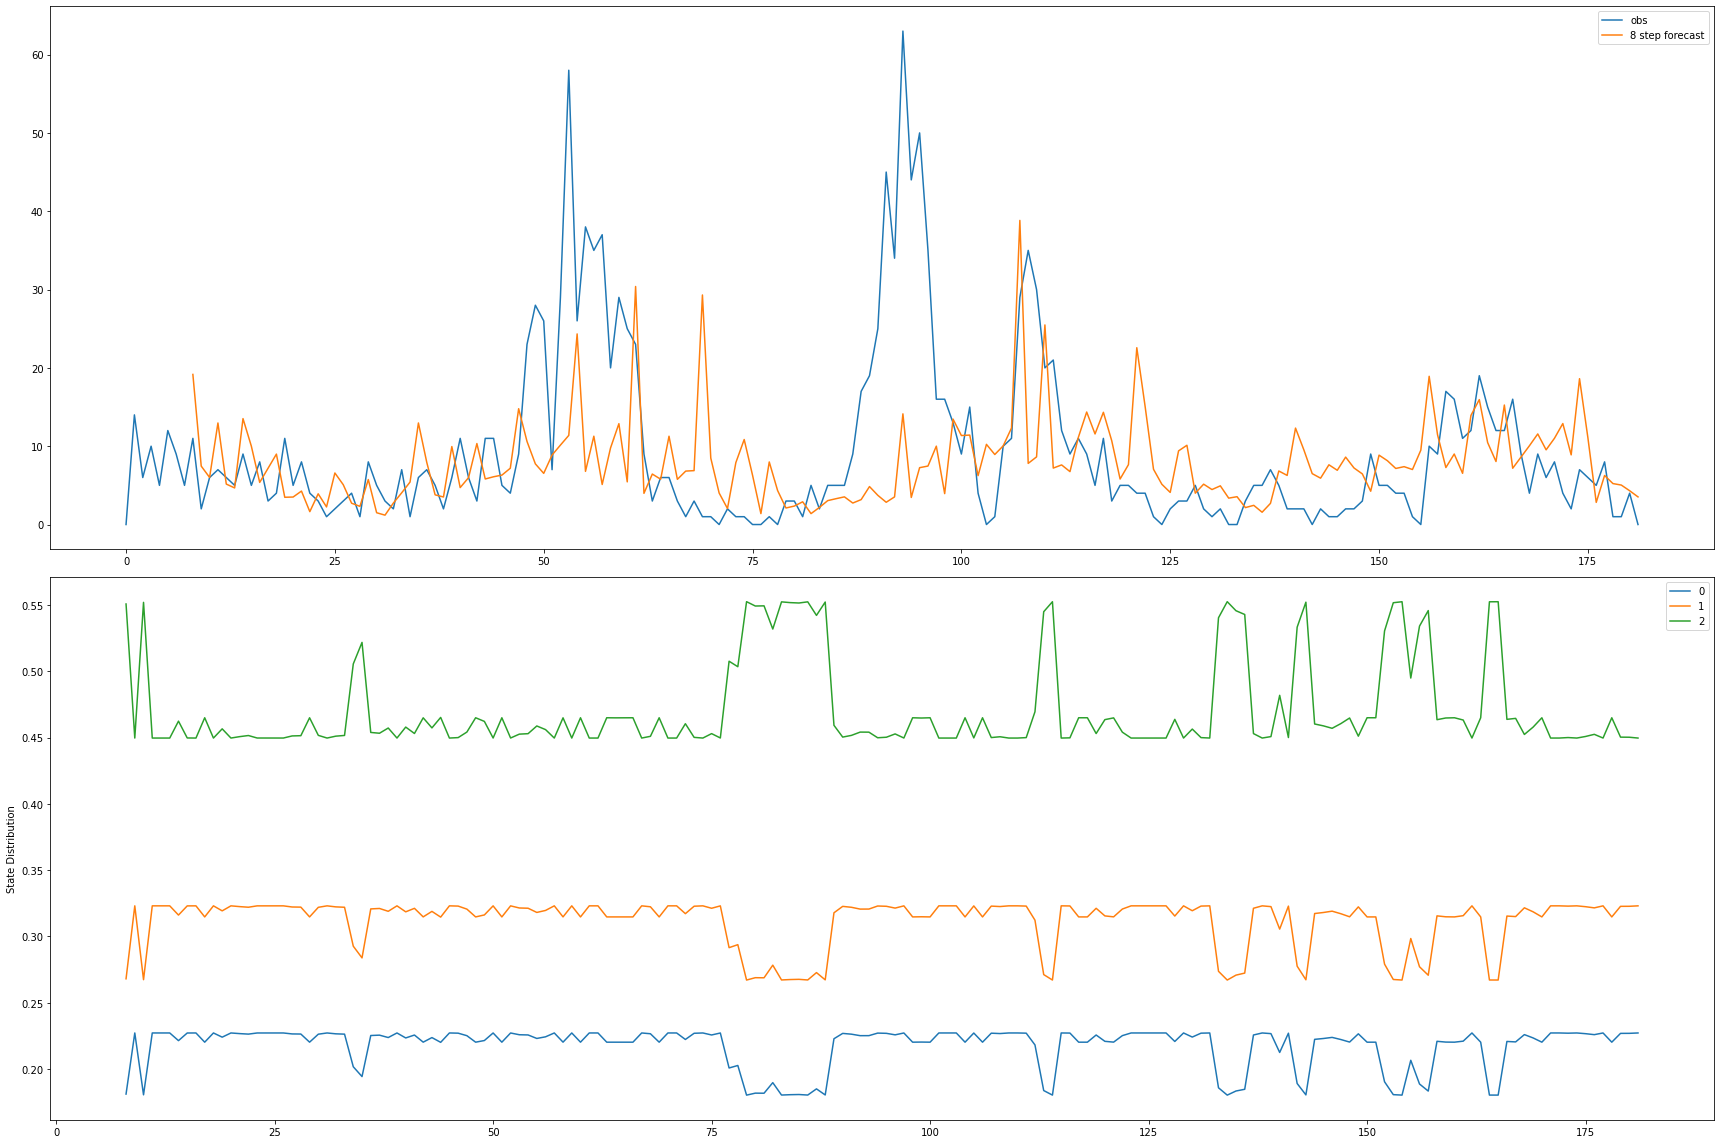

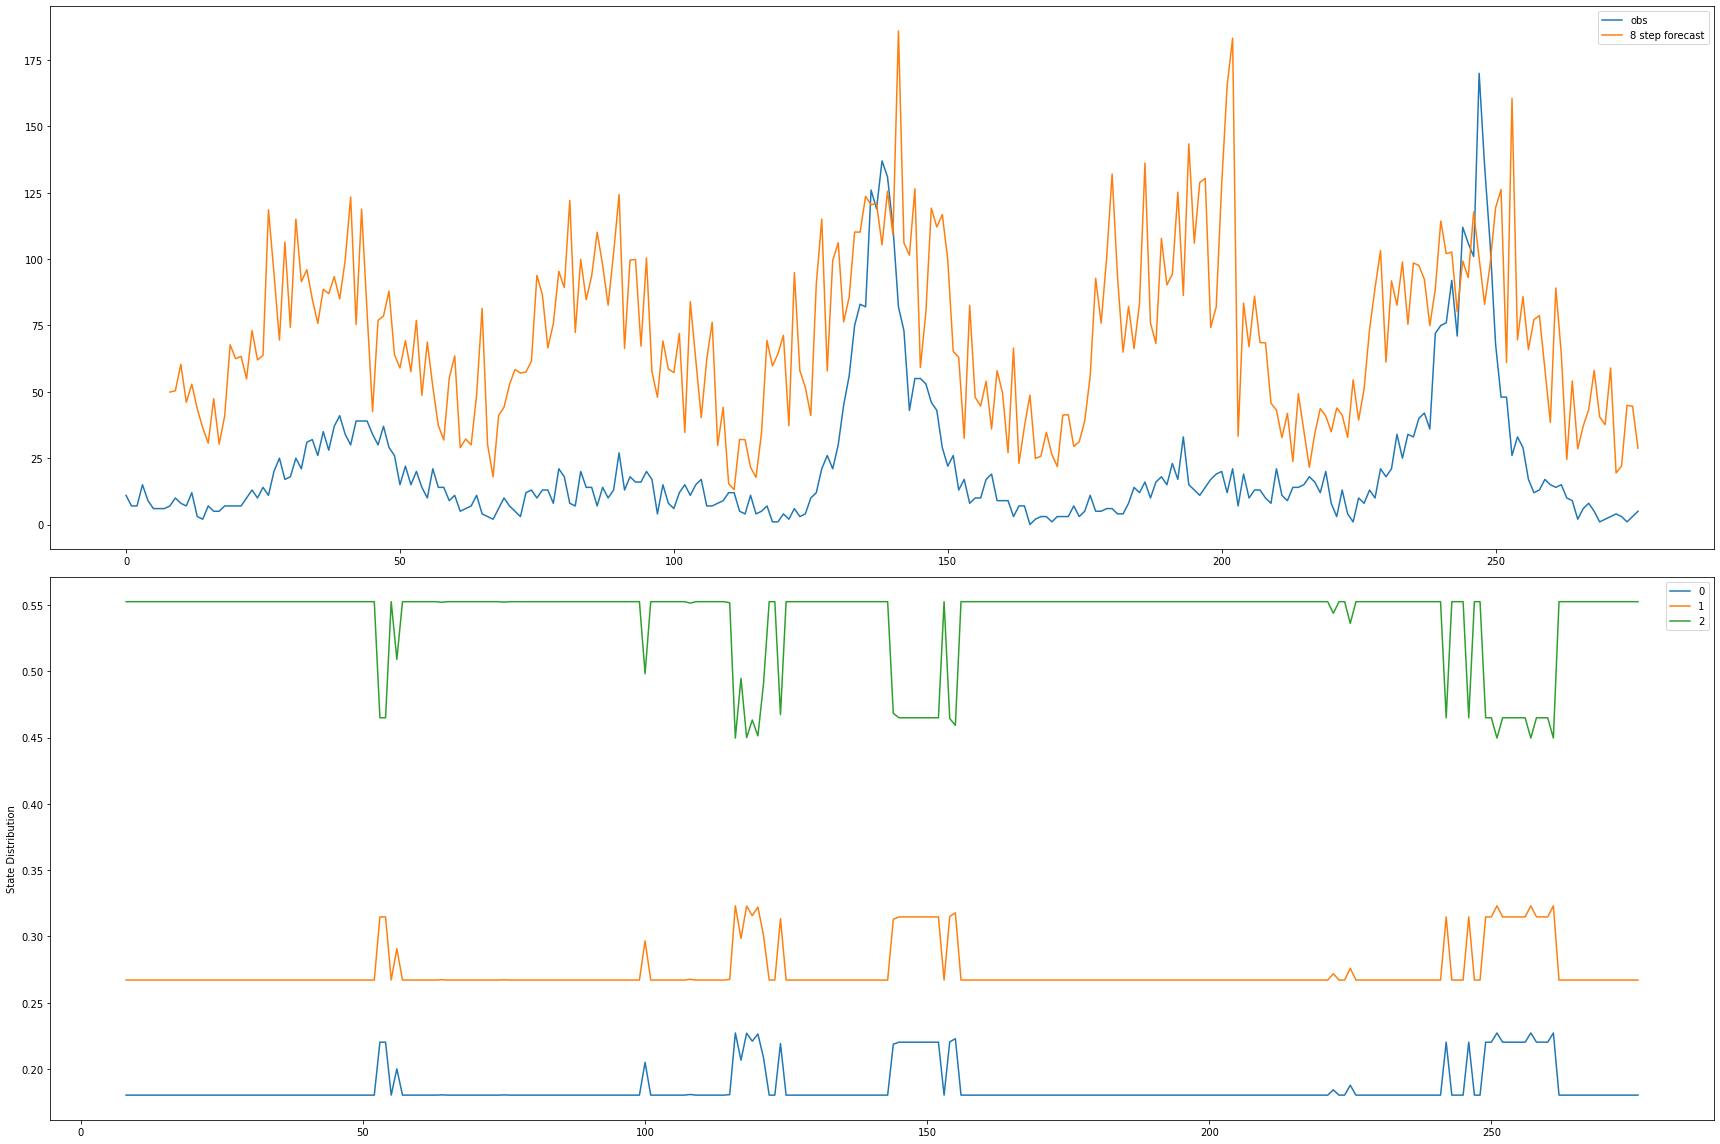

In [20]:
t0 = 0
for i in range(2):
    fig, ax = plt.subplots(nrows=2, figsize=(24, 16))
    t1 = len(event_data_validate['y'][i])+t0
    t = np.arange(t1-t0)
    y = event_data_validate['y'][i]
    ax[0].plot(t, y, label='obs')
    ax[0].plot(t, forecasts[i]['map'], label='8 step forecast')
    alpha = 0.05
    # ax[0].fill_between(t, forecasts[i]['lower'],
    #                 forecasts[i]['upper'],
    #                 facecolor='orange', alpha=0.5)
    most_likely_states = np.argmax(states_prob[i].values, axis=1)
    # for x_, y_ in zip(t, y):
    #     if np.isnan(states_prob[i].values[x_, 0]):
    #         continue
    #     ax[0].text(x_, y_+1, "%i" % most_likely_states[int(x_)], color="black", fontsize=12)
    ax[0].legend()
    for k in range(model.num_states):
        ax[1].plot(t, states_prob[i][k], label=k)
    ax[1].legend()
    ax[1].set_ylabel('State Distribution')
    t0 += t1
    plt.tight_layout()
    plt.savefig('forecast_%s.png' % cities[i])
    print("[%s] Forecast MAE: %.4f" % (cities[i], np.abs(forecasts[i]['map']-y).mean()))